# Setup

## Install library

In [1]:
!pip install sastrawi
!pip install swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16507 sha256=cb978d6ea8bc3a4b6f8892f19608d67f21d2f5c30e01fea997cf0793758cdfcf
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built swifter


## Import library

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
import swifter
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import shutil
from google.colab import drive, files

# Load Dataset & Exploratory Data Analysis

## Import dataset from GitHub

In [4]:
# Factual: Detik & Kompas
df1 = pd.read_csv("https://raw.githubusercontent.com/tantowjy/archive/main/dataset/bangkit24-hoax-detection/dataset-factual-detik-and-kompas.csv")
df1 = df1.drop(columns=['Unnamed: 0', 'link', 'date'])

# Factual: Tempo
df2 = pd.read_csv("https://raw.githubusercontent.com/tantowjy/archive/main/dataset/bangkit24-hoax-detection/dataset-tempo-benar.csv")
df2 = df2.drop(columns=['link', 'date'])

# Factual: Kompas (Clarification)
df3 = pd.read_csv("https://raw.githubusercontent.com/tantowjy/archive/main/dataset/bangkit24-hoax-detection/dataset-kompas-klarifikasi.csv")
df3 = df3.drop(columns=['link', 'date'])

# Fake: Antara
df4 = pd.read_csv("https://raw.githubusercontent.com/tantowjy/archive/main/dataset/bangkit24-hoax-detection/dataset-antara-hoaks.csv")
df4 = df4.drop(columns=['Unnamed: 0', 'link', 'date'])

# Fake: Kompas
df5 = pd.read_csv("https://raw.githubusercontent.com/tantowjy/archive/main/dataset/bangkit24-hoax-detection/dataset-kompas-hoaks.csv")
df5 = df5.drop(columns=['Unnamed: 0', 'link', 'date'])

# Fake: Tempo
df6 = pd.read_csv("https://raw.githubusercontent.com/tantowjy/archive/main/dataset/bangkit24-hoax-detection/dataset-tempo-hoaks.csv")
df6 = df6.drop(columns=['Unnamed: 0', 'link', 'date'])

# Fake: Turnbackhoax
df7 = pd.read_csv("https://raw.githubusercontent.com/tantowjy/archive/main/dataset/bangkit24-hoax-detection/dataset-turnbackhoax.csv")
df7 = df7.drop(columns=['Unnamed: 0', 'link', 'date'])
df7 = df7.sample(n=2400, random_state=42)

# Factual & Fake: Pukulenam
df8 = pd.read_csv("https://raw.githubusercontent.com/tantowjy/archive/main/dataset/bangkit24-hoax-detection/dataset-pukulenam.csv")

df = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8], ignore_index=True)
df.to_csv('dataset-final.csv', index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15956 entries, 0 to 15955
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    15956 non-null  object
 1   content  15955 non-null  object
 2   is_fake  15956 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 374.1+ KB


In [ ]:
files.download("dataset-final.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Exploratory Data Analysis

### Class distribution

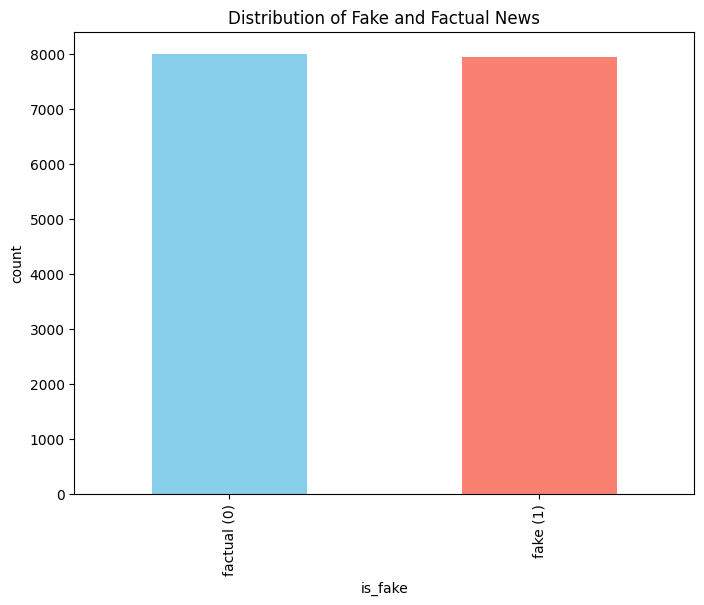

In [5]:
# count the occurrences of each class in 'is_fake'
count_classes = df['is_fake'].value_counts()

# plot the distribution as a bar chart
plt.figure(figsize=(8, 6))
count_classes.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Fake and Factual News')
plt.xlabel('is_fake')
plt.ylabel('count')
plt.xticks(ticks=[0, 1], labels=['factual (0)', 'fake (1)'])
plt.show()

### Missing values

In [6]:
df.isna().sum()

title      0
content    1
is_fake    0
dtype: int64

### Median and mean word count


In [7]:
# add a column for the word count
df['text'] = df['title'] + ' ' + df['content']
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# calculate the median word count for each label
median_word_count_label_0 = df[df['is_fake'] == 0]['word_count'].median()
median_word_count_label_1 = df[df['is_fake'] == 1]['word_count'].median()

median_word_count_label_0, median_word_count_label_1

(299.0, 291.0)

In [8]:
# calculate the median word count for each label
mean_word_count_label_0 = df[df['is_fake'] == 0]['word_count'].mean()
mean_word_count_label_1 = df[df['is_fake'] == 1]['word_count'].mean()

mean_word_count_label_0, mean_word_count_label_1

(318.70984781788457, 351.8525921299188)

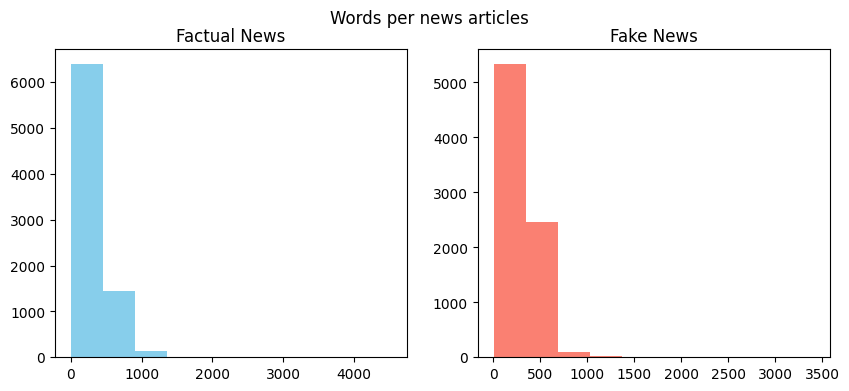

In [9]:
# plot word count
fig, (fact, fake) = plt.subplots(1, 2, figsize=(10, 4))

fact_words = df[df['is_fake'] == 1]['word_count']
fake_words = df[df['is_fake'] == 0]['word_count']

fact.hist(fact_words, color='skyblue')
fake.hist(fake_words, color='salmon')

fact.set_title('Factual News')
fake.set_title('Fake News')

fig.suptitle('Words per news articles')
plt.show()

# Data Preprocessing

## Stopword removal and lemmatization

In [10]:
# create sastrawi stopword
stopword_factory = StopWordRemoverFactory()
stopword = stopword_factory.create_stop_word_remover()

# create sastrawi stemmer
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

In [11]:
# functions for cleaning, removing stopwords
def preprocess_text(text):
    text = str(text)

    # change text to lowercase
    text = text.lower()

    # change link with http/https patterns
    text = re.sub(r'http\S+', '', text)

    # remove hashtag and username
    text = re.sub(r'(@\w+|#\w+)', '', text)

    # remove character other than a-z and A-Z
    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    # replace new line '\n' with space
    text = re.sub(r'\n', ' ', text)

    # remove stopword with sastrawi library
    text = stopword.remove(text)

    # do stemming with sastrawi library
    text = stemmer.stem(text)

    # removing more than one space
    text = re.sub(r'\s{2,}', ' ', text)

    return text

In [12]:
# dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15956 entries, 0 to 15955
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       15956 non-null  object
 1   content     15955 non-null  object
 2   is_fake     15956 non-null  int64 
 3   text        15955 non-null  object
 4   word_count  15956 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 623.4+ KB


In [ ]:
# text preprocessing
df['text'] = df['text'].swifter.apply(preprocess_text)

Pandas Apply:   0%|          | 0/15956 [00:00<?, ?it/s]

## Save text preprocessing result

In [ ]:
# save data preprocessing result
df.to_csv("dataset-final-preprocess.csv", index=False)
df.to_json("dataset-final-preprocess.json")

In [ ]:
files.download("dataset-final-preprocess.csv")
files.download("dataset-final-preprocess.json")

In [16]:
df = pd.read_csv("https://raw.githubusercontent.com/tantowjy/archive/main/dataset/bangkit24-hoax-detection/dataset-final/dataset-final-preprocess.csv")

## Check median and mean word count after preprocessing

In [17]:
# add a column for the word count
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# calculate the median word count for each label
median_word_count_label_0 = df[df['is_fake'] == 0]['word_count'].median()
median_word_count_label_1 = df[df['is_fake'] == 1]['word_count'].median()

median_word_count_label_0, median_word_count_label_1

(241.0, 233.0)

In [18]:
# calculate the median word count for each label
mean_word_count_label_0 = df[df['is_fake'] == 0]['word_count'].mean()
mean_word_count_label_1 = df[df['is_fake'] == 1]['word_count'].mean()

mean_word_count_label_0, mean_word_count_label_1

(256.66192931706706, 277.53454091193004)

## Split the datasets

In [19]:
# delete null row
df = df.dropna()

# separating features and labels
X = df['text'].values
y = df['is_fake'].values

In [20]:
# Split the dataset into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Baseline Model with ScikitLearn

Logistic Regression: 0.95
Support Vector Machine: 0.96
K-Nearest Neighbors: 0.89
Decision Tree: 0.96
Random Forest: 0.95
Gradient Boosting: 0.98


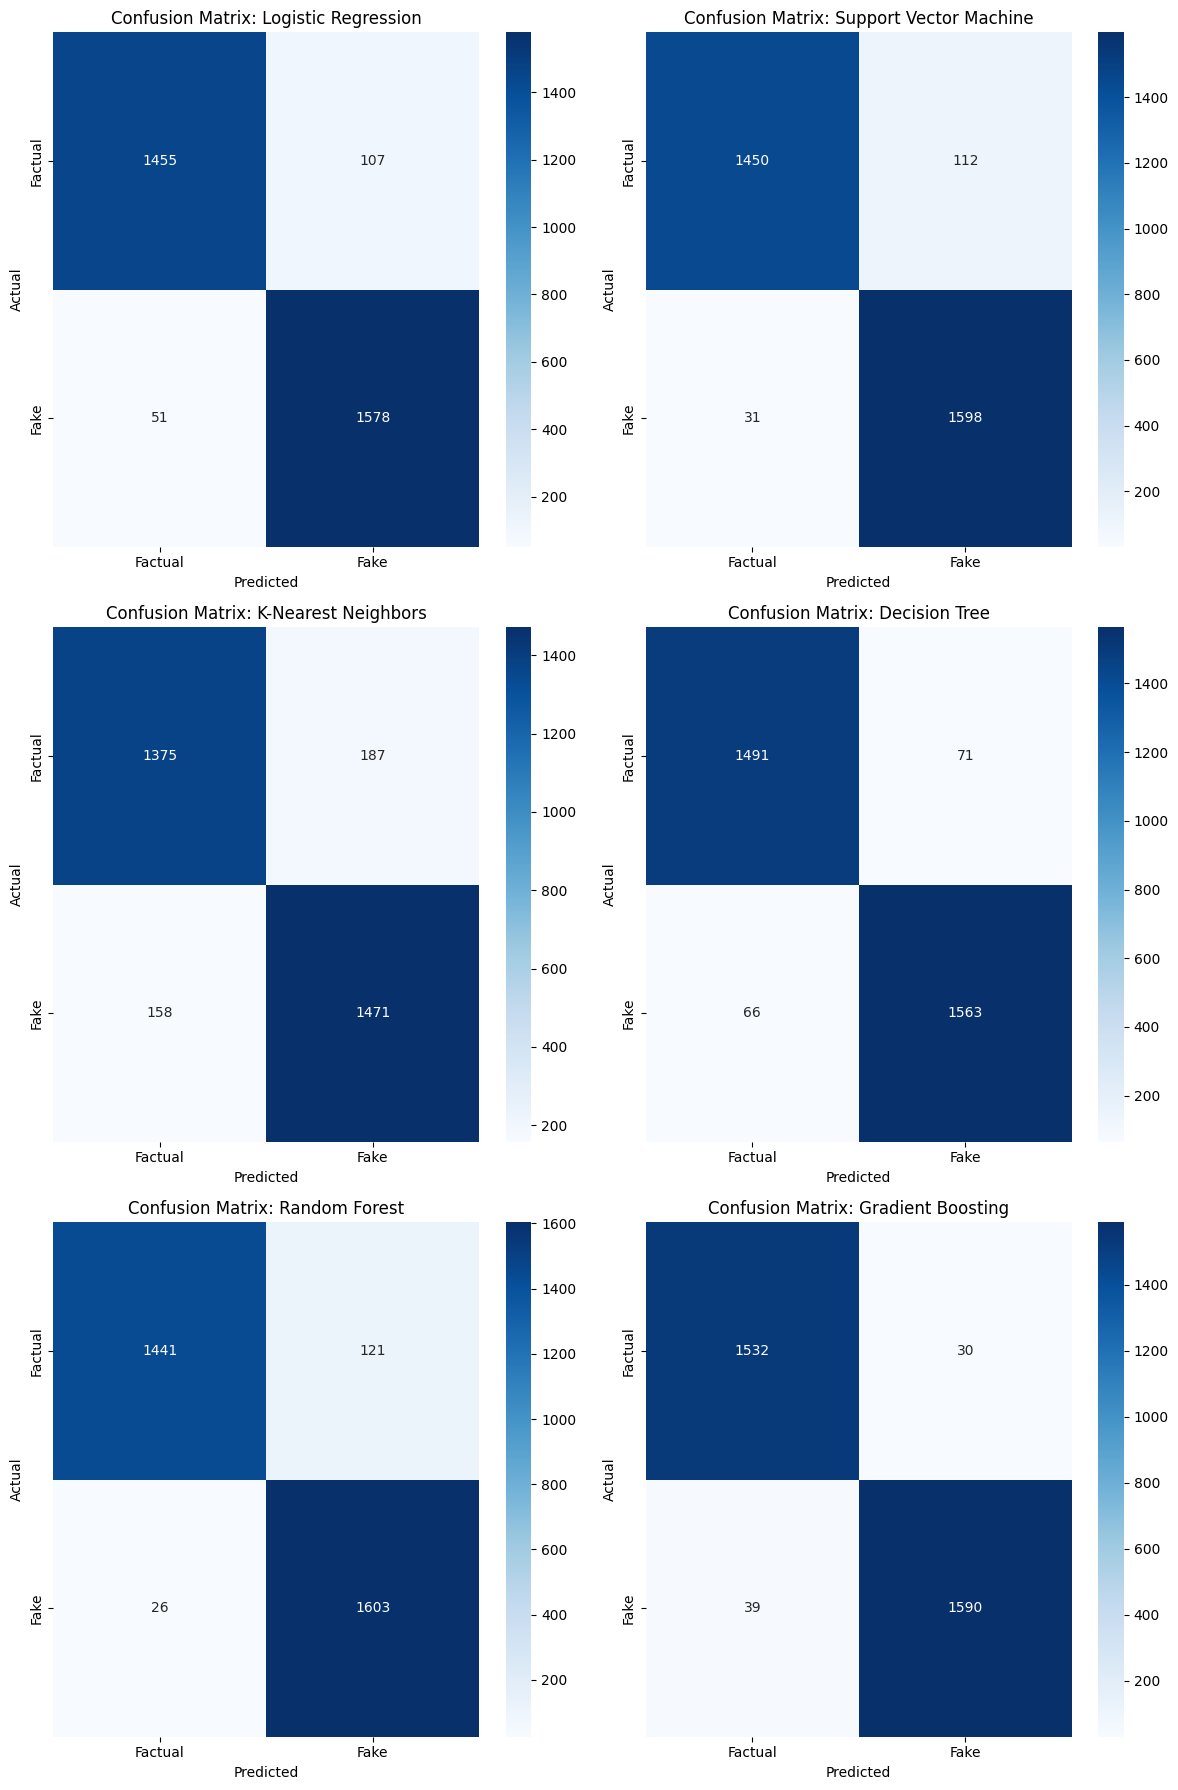

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

# initialize classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Support Vector Machine": SVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
}

# create a pipeline for each classifier
pipelines = {name: Pipeline([('tfidf', TfidfVectorizer()), ('clf', clf)]) for name, clf in classifiers.items()}

# train and evaluate classifiers
n_classifiers = len(pipelines)
n_cols = 2
n_rows = (n_classifiers + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 6*n_rows))
axes = axes.flatten()

for idx, (name, pipeline) in enumerate(pipelines.items()):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    # calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name}: {accuracy:.2f}")

    # compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Factual', 'Fake'], yticklabels=['Factual', 'Fake'], ax=axes[idx])
    axes[idx].set_title(f"Confusion Matrix: {name}")
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')

# hide any remaining empty subplots
for j in range(idx + 1, n_rows * n_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Create Tokenizer

In [21]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [22]:
# Create tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

# Converting text to numeric squences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

# Padding the squences
padded_train_sequences = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Create Model

## Import library

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import GlobalAveragePooling1D, BatchNormalization
from tensorflow.keras.layers import Flatten, GlobalMaxPool1D, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2, l1_l2

## Model A1

In [24]:
# create model A1
model_A1 = Sequential()
model_A1.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model_A1.add(GlobalAveragePooling1D())
model_A1.add(Dense(24, activation='relu'))
model_A1.add(Dropout(0.3))
model_A1.add(Dense(8, activation='relu'))
model_A1.add(Dropout(0.3))
model_A1.add(Dense(1, activation='sigmoid'))

model_A1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d (  (None, 16)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dropout (Dropout)           (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 200       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                        

In [25]:
# compile model
model_A1.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# model training
history = model_A1.fit(padded_train_sequences, y_train,
                      epochs=30,
                      validation_data=(padded_test_sequences, y_test),
                      batch_size=64,
                      callbacks=[early_stopping])

Epoch 1/30
200/200 [==============================] - 4s 11ms/step - loss: 0.6908 - accuracy: 0.6500 - val_loss: 0.6858 - val_accuracy: 0.9336
Epoch 2/30
200/200 [==============================] - 2s 11ms/step - loss: 0.6780 - accuracy: 0.7744 - val_loss: 0.6657 - val_accuracy: 0.9411
Epoch 3/30
200/200 [==============================] - 2s 10ms/step - loss: 0.6501 - accuracy: 0.8338 - val_loss: 0.6242 - val_accuracy: 0.9427
Epoch 4/30
200/200 [==============================] - 3s 14ms/step - loss: 0.6003 - accuracy: 0.8811 - val_loss: 0.5586 - val_accuracy: 0.9420
Epoch 5/30
200/200 [==============================] - 1s 7ms/step - loss: 0.5329 - accuracy: 0.9018 - val_loss: 0.4782 - val_accuracy: 0.9433
Epoch 6/30
200/200 [==============================] - 1s 6ms/step - loss: 0.4562 - accuracy: 0.9134 - val_loss: 0.3924 - val_accuracy: 0.9439
Epoch 7/30
200/200 [==============================] - 1s 6ms/step - loss: 0.3840 - accuracy: 0.9212 - val_loss: 0.3200 - val_accuracy: 0.9445
Ep

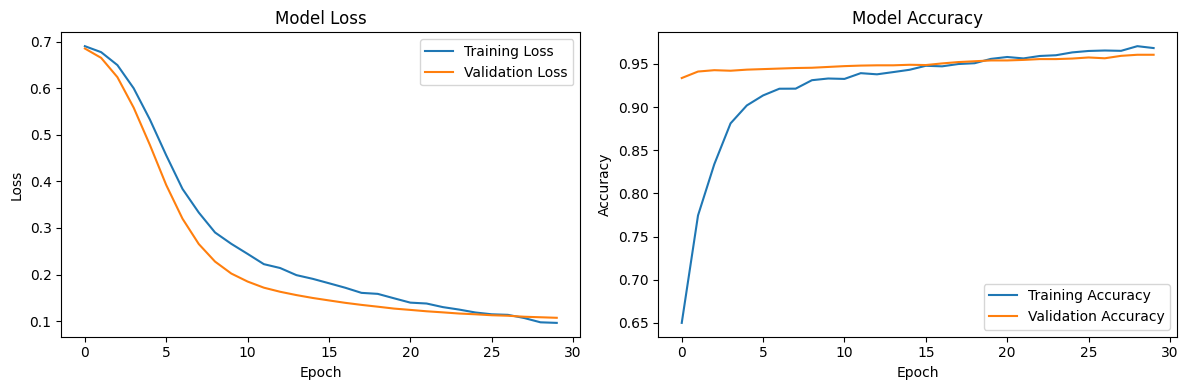

In [26]:
# training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Evaluate and save model

100/100 [==============================] - 0s 2ms/step - loss: 0.1070 - accuracy: 0.9605
Test Accuracy: 96.05%
100/100 [==============================] - 0s 1ms/step


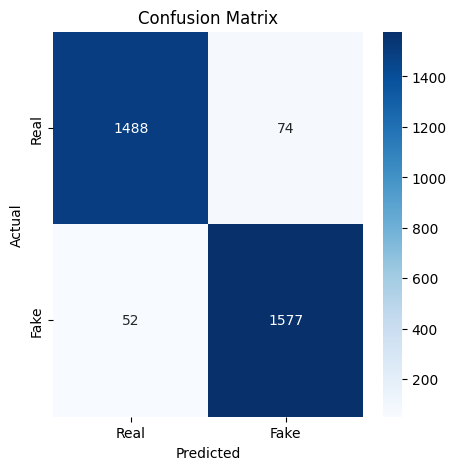

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
import pickle

# Evaluate the model
loss, accuracy = model_A1.evaluate(padded_test_sequences, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred_prob = model_A1.predict(padded_test_sequences)
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the model with HDF5 format
model_A1.save('hoax_detection_A1.h5')

# Save the model with pickle format
with open('tokenizer_A1.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

### Convert to TFLite

In [28]:
# Convert the model with Select TF ops
converter = tf.lite.TFLiteConverter.from_keras_model(model_A1)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model
with open('hoax_detection_A1.tflite', 'wb') as f:
    f.write(tflite_model)

print('Model has been saved as TensorFlow Lite format.')

Model has been saved as TensorFlow Lite format.


## Model A2

In [29]:
# create model A2
model_A2 = Sequential()
model_A2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model_A2.add(GlobalAveragePooling1D())
model_A2.add(Dense(32, activation='relu'))
model_A2.add(Dropout(0.3))
model_A2.add(Dense(1, activation='sigmoid'))

model_A2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_3 (Dense)             (None, 32)                544       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 160577 (627.25 KB)
Trainable params: 160577 (627.25 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [30]:
# compile model
model_A2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# model training
history = model_A2.fit(padded_train_sequences, y_train,
                      epochs=20,
                      validation_data=(padded_test_sequences, y_test),
                      batch_size=128,
                      callbacks=[early_stopping])

Epoch 1/20
100/100 [==============================] - 5s 19ms/step - loss: 0.6917 - accuracy: 0.6655 - val_loss: 0.6886 - val_accuracy: 0.8825
Epoch 2/20
100/100 [==============================] - 2s 18ms/step - loss: 0.6829 - accuracy: 0.8814 - val_loss: 0.6761 - val_accuracy: 0.9251
Epoch 3/20
100/100 [==============================] - 2s 15ms/step - loss: 0.6667 - accuracy: 0.9173 - val_loss: 0.6562 - val_accuracy: 0.9295
Epoch 4/20
100/100 [==============================] - 1s 13ms/step - loss: 0.6421 - accuracy: 0.9254 - val_loss: 0.6282 - val_accuracy: 0.9351
Epoch 5/20
100/100 [==============================] - 1s 13ms/step - loss: 0.6106 - accuracy: 0.9314 - val_loss: 0.5932 - val_accuracy: 0.9386
Epoch 6/20
100/100 [==============================] - 1s 14ms/step - loss: 0.5721 - accuracy: 0.9342 - val_loss: 0.5525 - val_accuracy: 0.9389
Epoch 7/20
100/100 [==============================] - 2s 16ms/step - loss: 0.5300 - accuracy: 0.9365 - val_loss: 0.5089 - val_accuracy: 0.9395

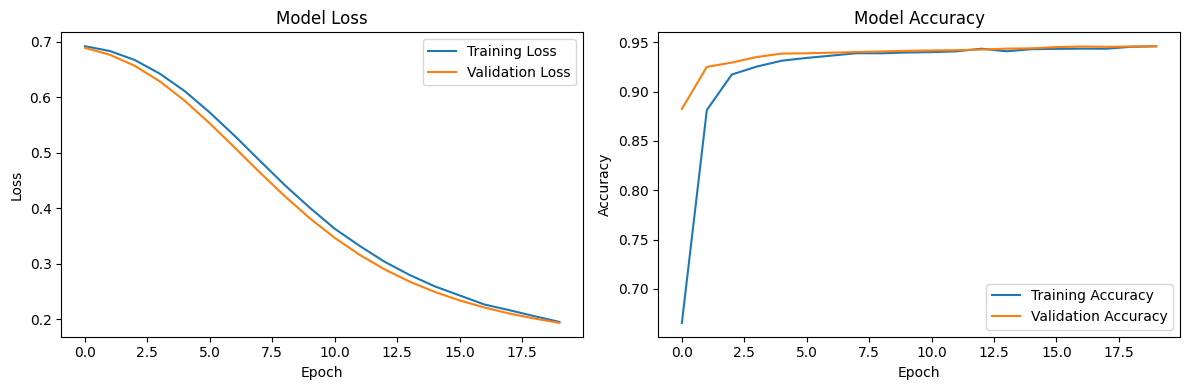

In [31]:
# training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Evaluate and save model

100/100 [==============================] - 0s 2ms/step - loss: 0.1935 - accuracy: 0.9461
Test Accuracy: 94.61%
100/100 [==============================] - 0s 1ms/step


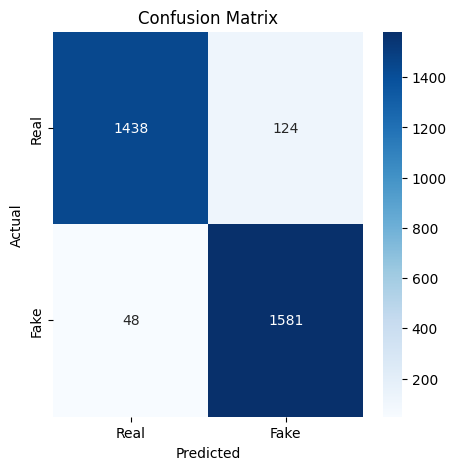

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
import pickle

# Evaluate the model
loss, accuracy = model_A2.evaluate(padded_test_sequences, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred_prob = model_A2.predict(padded_test_sequences)
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the model with HDF5 format
model_A2.save('hoax_detection_A2.h5')

# Save the model with pickle format
with open('tokenizer_A2.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

### Convert to TFLite

In [33]:
# Convert the model with Select TF ops
converter = tf.lite.TFLiteConverter.from_keras_model(model_A2)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model
with open('hoax_detection_A2.tflite', 'wb') as f:
    f.write(tflite_model)

print('Model has been saved as TensorFlow Lite format.')

Model has been saved as TensorFlow Lite format.


## Model A3

In [34]:
# create model A3
model_A3 = Sequential()
model_A3.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model_A3.add(GlobalAveragePooling1D())
model_A3.add(Dense(24, activation='relu'))
model_A3.add(BatchNormalization())
model_A3.add(Dropout(0.5))
model_A3.add(Dense(6, activation='relu'))
model_A3.add(BatchNormalization())
model_A3.add(Dropout(0.5))
model_A3.add(Dense(1, activation='sigmoid'))

model_A3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_2  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_5 (Dense)             (None, 24)                408       
                                                                 
 batch_normalization (Batch  (None, 24)                96        
 Normalization)                                                  
                                                                 
 dropout_3 (Dropout)         (None, 24)                0         
                                                                 
 dense_6 (Dense)             (None, 6)                

In [35]:
# compile model
model_A3.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# model training
history = model_A3.fit(padded_train_sequences, y_train,
                      epochs=20,
                      validation_data=(padded_test_sequences, y_test),
                      batch_size=64,
                      callbacks=[early_stopping])

Epoch 1/20
200/200 [==============================] - 2s 6ms/step - loss: 0.7375 - accuracy: 0.5876 - val_loss: 0.6864 - val_accuracy: 0.5136
Epoch 2/20
200/200 [==============================] - 2s 10ms/step - loss: 0.5451 - accuracy: 0.7303 - val_loss: 0.6018 - val_accuracy: 0.9013
Epoch 3/20
200/200 [==============================] - 1s 5ms/step - loss: 0.4395 - accuracy: 0.8048 - val_loss: 0.3668 - val_accuracy: 0.9354
Epoch 4/20
200/200 [==============================] - 1s 6ms/step - loss: 0.3790 - accuracy: 0.8409 - val_loss: 0.2395 - val_accuracy: 0.9411
Epoch 5/20
200/200 [==============================] - 2s 9ms/step - loss: 0.3313 - accuracy: 0.8772 - val_loss: 0.2025 - val_accuracy: 0.9452
Epoch 6/20
200/200 [==============================] - 2s 8ms/step - loss: 0.3068 - accuracy: 0.8906 - val_loss: 0.1819 - val_accuracy: 0.9474
Epoch 7/20
200/200 [==============================] - 2s 8ms/step - loss: 0.2681 - accuracy: 0.9093 - val_loss: 0.1661 - val_accuracy: 0.9514
Epoch

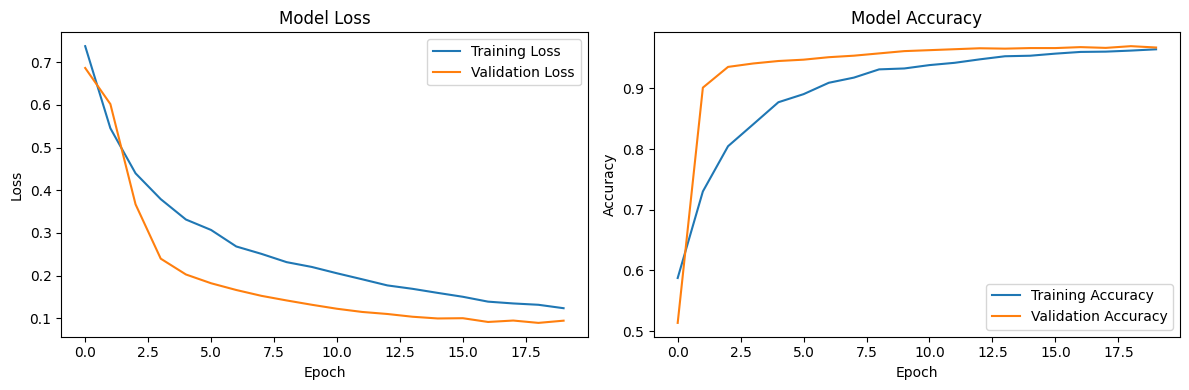

In [36]:
# training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Evaluate and save model

100/100 [==============================] - 0s 2ms/step - loss: 0.0942 - accuracy: 0.9674
Test Accuracy: 96.74%
100/100 [==============================] - 0s 2ms/step


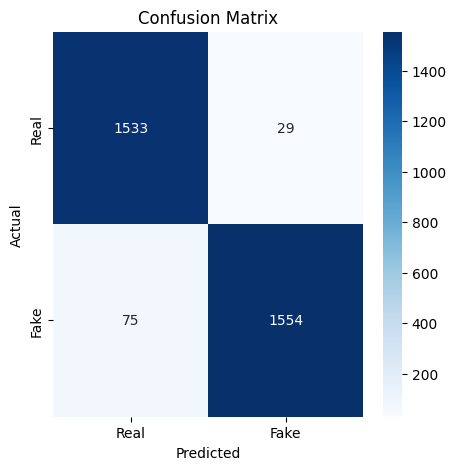

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
import pickle

# Evaluate the model
loss, accuracy = model_A3.evaluate(padded_test_sequences, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred_prob = model_A3.predict(padded_test_sequences)
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the model with HDF5 format
model_A3.save('hoax_detection_A3.h5')

# Save the model with pickle format
with open('tokenizer_A3.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

### Convert to TFLite

In [38]:
# Convert the model with Select TF ops
converter = tf.lite.TFLiteConverter.from_keras_model(model_A3)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model
with open('hoax_detection_A3.tflite', 'wb') as f:
    f.write(tflite_model)

print('Model has been saved as TensorFlow Lite format.')

Model has been saved as TensorFlow Lite format.


## Model B1

In [39]:
# create model B1
model_B1 = Sequential()
model_B1.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model_B1.add(Bidirectional(LSTM(24, return_sequences=False)))
model_B1.add(Dropout(0.2))
model_B1.add(Dense(1, activation='sigmoid'))

model_B1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 16)           160000    
                                                                 
 bidirectional (Bidirection  (None, 48)                7872      
 al)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 48)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 49        
                                                                 
Total params: 167921 (655.94 KB)
Trainable params: 167921 (655.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
# compile model
model_B1.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# model training
history = model_B1.fit(padded_train_sequences, y_train,
                      epochs=30,
                      validation_data=(padded_test_sequences, y_test),
                      batch_size=64,
                      callbacks=[early_stopping])

Epoch 1/30
200/200 [==============================] - 24s 101ms/step - loss: 0.6882 - accuracy: 0.6879 - val_loss: 0.6726 - val_accuracy: 0.9054
Epoch 2/30
200/200 [==============================] - 19s 95ms/step - loss: 0.3452 - accuracy: 0.9226 - val_loss: 0.1958 - val_accuracy: 0.9373
Epoch 3/30
200/200 [==============================] - 18s 91ms/step - loss: 0.1770 - accuracy: 0.9452 - val_loss: 0.1741 - val_accuracy: 0.9423
Epoch 4/30
200/200 [==============================] - 19s 94ms/step - loss: 0.1547 - accuracy: 0.9507 - val_loss: 0.1636 - val_accuracy: 0.9448
Epoch 5/30
200/200 [==============================] - 19s 97ms/step - loss: 0.1346 - accuracy: 0.9585 - val_loss: 0.1660 - val_accuracy: 0.9389
Epoch 6/30
200/200 [==============================] - 18s 90ms/step - loss: 0.1233 - accuracy: 0.9631 - val_loss: 0.1520 - val_accuracy: 0.9470
Epoch 7/30
200/200 [==============================] - 18s 89ms/step - loss: 0.1069 - accuracy: 0.9689 - val_loss: 0.1429 - val_accuracy

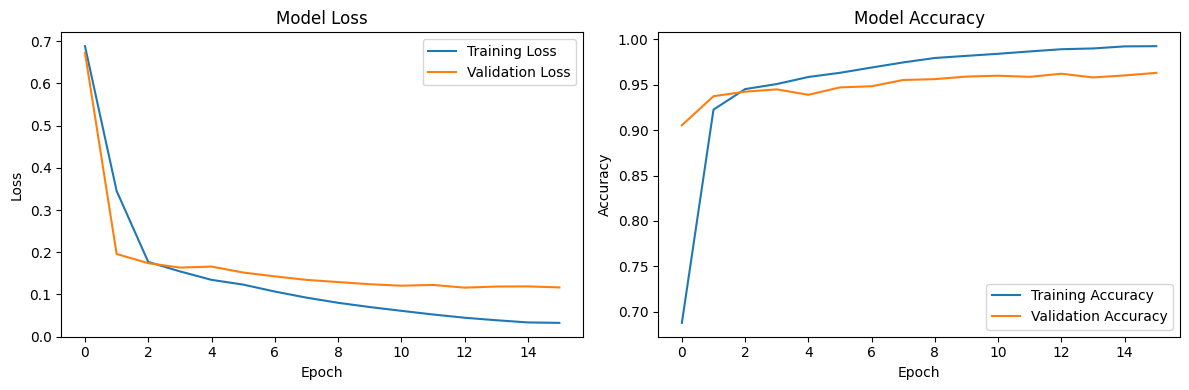

In [41]:
# training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Evaluate and save model

100/100 [==============================] - 2s 20ms/step - loss: 0.1162 - accuracy: 0.9621
Test Accuracy: 96.21%
100/100 [==============================] - 2s 16ms/step


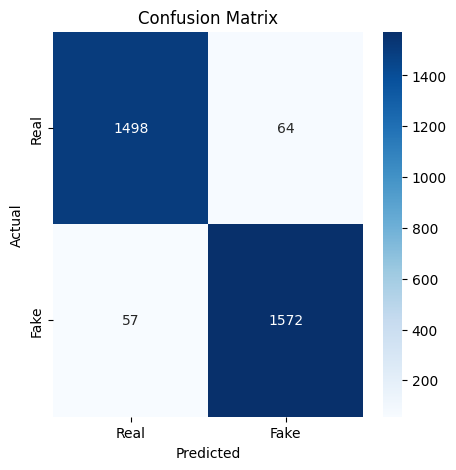

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
import pickle

# Evaluate the model
loss, accuracy = model_B1.evaluate(padded_test_sequences, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred_prob = model_B1.predict(padded_test_sequences)
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the model with HDF5 format
model_B1.save('hoax_detection_B1.h5')

# Save the model with pickle format
with open('tokenizer_B1.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

### Convert to TFLite

In [43]:
# Convert the model with Select TF ops
converter = tf.lite.TFLiteConverter.from_keras_model(model_B1)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model
with open('hoax_detection_B1.tflite', 'wb') as f:
    f.write(tflite_model)

print('Model has been saved as TensorFlow Lite format.')

Model has been saved as TensorFlow Lite format.


## Model B2

In [44]:
# create model B2
model_B2 = Sequential()
model_B2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model_B2.add(Bidirectional(LSTM(16, return_sequences=True, kernel_regularizer=l2(0.01))))
model_B2.add(Bidirectional(LSTM(8)))
model_B2.add(Dropout(0.5))
model_B2.add(Dense(1, activation='sigmoid'))

model_B2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 16)           160000    
                                                                 
 bidirectional_1 (Bidirecti  (None, 100, 32)           4224      
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 16)                2624      
 onal)                                                           
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 166865 (651.82 KB)
Trainable params: 166

In [45]:
# compile model
model_B2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# model training
history = model_B2.fit(padded_train_sequences, y_train,
                      epochs=20,
                      validation_data=(padded_test_sequences, y_test),
                      batch_size=64,
                      callbacks=[early_stopping])

Epoch 1/20
200/200 [==============================] - 47s 194ms/step - loss: 1.1451 - accuracy: 0.6423 - val_loss: 1.0874 - val_accuracy: 0.8938
Epoch 2/20
200/200 [==============================] - 32s 158ms/step - loss: 0.8830 - accuracy: 0.8986 - val_loss: 0.5794 - val_accuracy: 0.9364
Epoch 3/20
200/200 [==============================] - 31s 154ms/step - loss: 0.5339 - accuracy: 0.9431 - val_loss: 0.4600 - val_accuracy: 0.9461
Epoch 4/20
200/200 [==============================] - 31s 154ms/step - loss: 0.4387 - accuracy: 0.9497 - val_loss: 0.3976 - val_accuracy: 0.9398
Epoch 5/20
200/200 [==============================] - 31s 157ms/step - loss: 0.3704 - accuracy: 0.9555 - val_loss: 0.3506 - val_accuracy: 0.9392
Epoch 6/20
200/200 [==============================] - 30s 149ms/step - loss: 0.3172 - accuracy: 0.9608 - val_loss: 0.3029 - val_accuracy: 0.9514
Epoch 7/20
200/200 [==============================] - 30s 151ms/step - loss: 0.2679 - accuracy: 0.9659 - val_loss: 0.2698 - val_ac

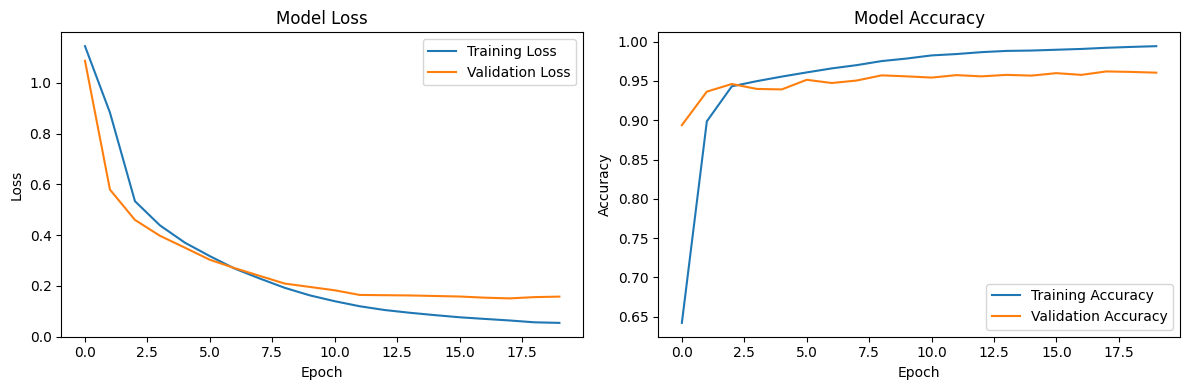

In [46]:
# training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Evaluate and save model

100/100 [==============================] - 3s 25ms/step - loss: 0.1576 - accuracy: 0.9605
Test Accuracy: 96.05%
100/100 [==============================] - 4s 25ms/step


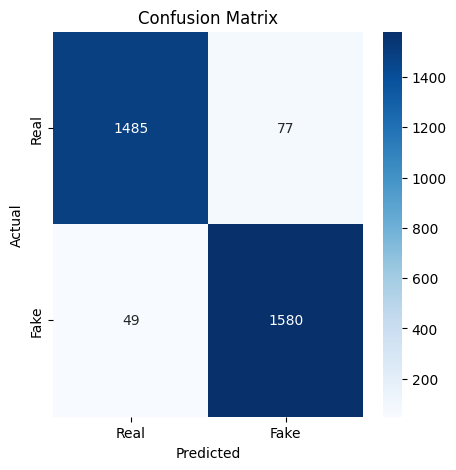

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
import pickle

# Evaluate the model
loss, accuracy = model_B2.evaluate(padded_test_sequences, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred_prob = model_B2.predict(padded_test_sequences)
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the model with HDF5 format
model_B2.save('hoax_detection_B2.h5')

# Save the model with pickle format
with open('tokenizer_B2.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

### Convert to TFLite

In [48]:
# Convert the model with Select TF ops
converter = tf.lite.TFLiteConverter.from_keras_model(model_B2)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model
with open('hoax_detection_B2.tflite', 'wb') as f:
    f.write(tflite_model)

print('Model has been saved as TensorFlow Lite format.')

Model has been saved as TensorFlow Lite format.


## Model B3

In [49]:
# create model B3
model_B3 = Sequential()
model_B3.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model_B3.add(Bidirectional(LSTM(24, return_sequences=True, kernel_regularizer=l1_l2(l1=0.01, l2=0.01))))
model_B3.add(Bidirectional(LSTM(6)))
model_B3.add(Dropout(0.5))
model_B3.add(Dense(1, activation='sigmoid'))

model_B3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 16)           160000    
                                                                 
 bidirectional_3 (Bidirecti  (None, 100, 48)           7872      
 onal)                                                           
                                                                 
 bidirectional_4 (Bidirecti  (None, 12)                2640      
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 12)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 13        
                                                                 
Total params: 170525 (666.11 KB)
Trainable params: 170

In [50]:
# compile model
model_B3.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# model training
history = model_B3.fit(padded_train_sequences, y_train,
                      epochs=20,
                      validation_data=(padded_test_sequences, y_test),
                      batch_size=64,
                      callbacks=[early_stopping])

Epoch 1/20
200/200 [==============================] - 45s 183ms/step - loss: 4.3820 - accuracy: 0.5615 - val_loss: 4.0278 - val_accuracy: 0.6872
Epoch 2/20
200/200 [==============================] - 36s 179ms/step - loss: 3.7041 - accuracy: 0.6631 - val_loss: 3.3867 - val_accuracy: 0.7938
Epoch 3/20
200/200 [==============================] - 32s 162ms/step - loss: 3.0780 - accuracy: 0.7832 - val_loss: 2.6974 - val_accuracy: 0.9157
Epoch 4/20
200/200 [==============================] - 33s 166ms/step - loss: 2.3640 - accuracy: 0.8861 - val_loss: 2.0746 - val_accuracy: 0.9119
Epoch 5/20
200/200 [==============================] - 35s 172ms/step - loss: 1.8529 - accuracy: 0.9115 - val_loss: 1.6041 - val_accuracy: 0.9217
Epoch 6/20
200/200 [==============================] - 34s 169ms/step - loss: 1.3965 - accuracy: 0.9293 - val_loss: 1.1610 - val_accuracy: 0.9408
Epoch 7/20
200/200 [==============================] - 32s 161ms/step - loss: 1.0293 - accuracy: 0.9367 - val_loss: 0.8604 - val_ac

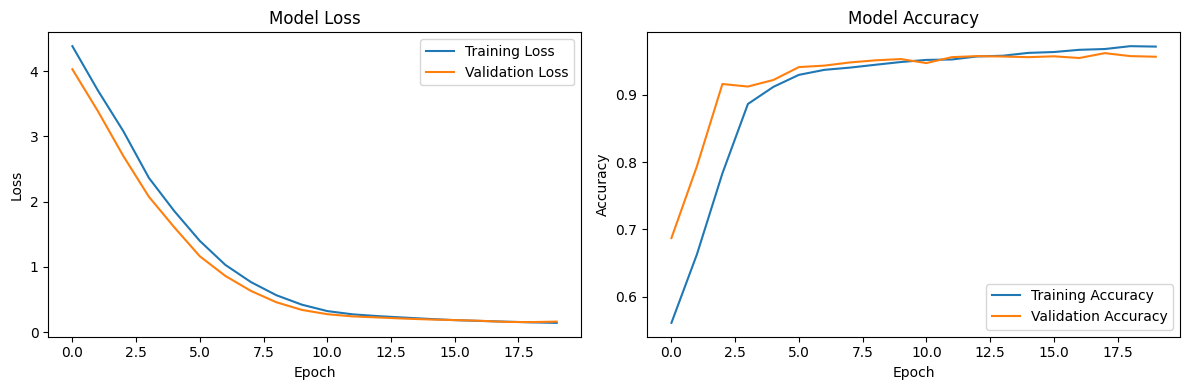

In [51]:
# training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Evaluate and save model

100/100 [==============================] - 4s 37ms/step - loss: 0.1596 - accuracy: 0.9561
Test Accuracy: 95.61%
100/100 [==============================] - 4s 27ms/step


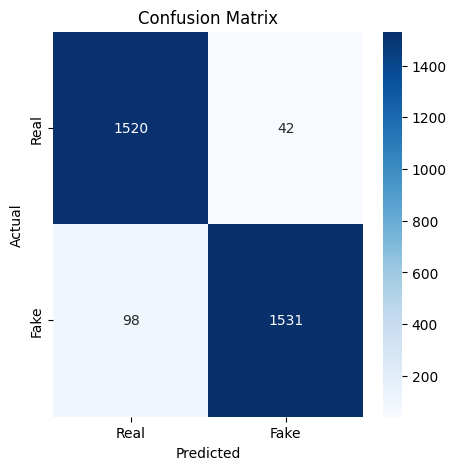

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [52]:
import pickle

# Evaluate the model
loss, accuracy = model_B3.evaluate(padded_test_sequences, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred_prob = model_B3.predict(padded_test_sequences)
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the model with HDF5 format
model_B3.save('hoax_detection_B3.h5')

# Save the model with pickle format
with open('tokenizer_B3.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

### Convert to TFLite

In [53]:
# Convert the model with Select TF ops
converter = tf.lite.TFLiteConverter.from_keras_model(model_B3)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model
with open('hoax_detection_B3.tflite', 'wb') as f:
    f.write(tflite_model)

print('Model has been saved as TensorFlow Lite format.')

Model has been saved as TensorFlow Lite format.


## Model C1

In [54]:
# create model C1
model_C1 = Sequential()
model_C1.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model_C1.add(LSTM(64, return_sequences=True))
model_C1.add(Dropout(0.3))
model_C1.add(LSTM(32))
model_C1.add(Dropout(0.3))
model_C1.add(Dense(24, activation='relu'))
model_C1.add(BatchNormalization())
model_C1.add(Dropout(0.3))
model_C1.add(Dense(8, activation='relu'))
model_C1.add(Dropout(0.3))
model_C1.add(Dense(1, activation='sigmoid'))

model_C1.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 16)           160000    
                                                                 
 lstm_5 (LSTM)               (None, 100, 64)           20736     
                                                                 
 dropout_8 (Dropout)         (None, 100, 64)           0         
                                                                 
 lstm_6 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_11 (Dense)            (None, 24)                792       
                                                                 
 batch_normalization_2 (Bat  (None, 24)               

In [55]:
# compile model
model_C1.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# model training
history = model_C1.fit(padded_train_sequences, y_train,
                      epochs=30,
                      validation_data=(padded_test_sequences, y_test),
                      batch_size=64,
                      callbacks=[early_stopping])

Epoch 1/30
200/200 [==============================] - 49s 216ms/step - loss: 0.5656 - accuracy: 0.7068 - val_loss: 0.5102 - val_accuracy: 0.9267
Epoch 2/30
200/200 [==============================] - 58s 291ms/step - loss: 0.2549 - accuracy: 0.9185 - val_loss: 0.1961 - val_accuracy: 0.9427
Epoch 3/30
200/200 [==============================] - 40s 201ms/step - loss: 0.1832 - accuracy: 0.9439 - val_loss: 0.1437 - val_accuracy: 0.9480
Epoch 4/30
200/200 [==============================] - 39s 193ms/step - loss: 0.1456 - accuracy: 0.9574 - val_loss: 0.1196 - val_accuracy: 0.9564
Epoch 5/30
200/200 [==============================] - 41s 204ms/step - loss: 0.1137 - accuracy: 0.9691 - val_loss: 0.1129 - val_accuracy: 0.9608
Epoch 6/30
200/200 [==============================] - 38s 192ms/step - loss: 0.0903 - accuracy: 0.9769 - val_loss: 0.1165 - val_accuracy: 0.9608
Epoch 7/30
200/200 [==============================] - 38s 191ms/step - loss: 0.0749 - accuracy: 0.9815 - val_loss: 0.1340 - val_ac

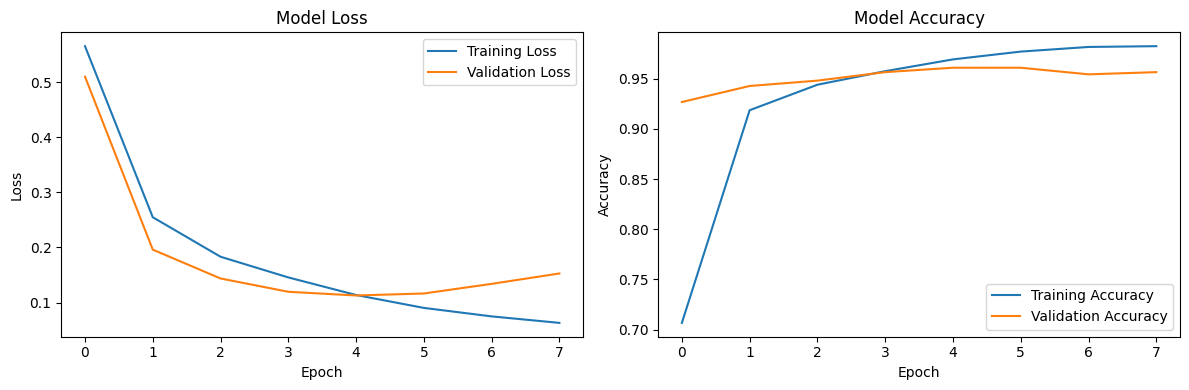

In [56]:
# training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Evaluate and save model

100/100 [==============================] - 3s 33ms/step - loss: 0.1129 - accuracy: 0.9608
Test Accuracy: 96.08%
100/100 [==============================] - 4s 34ms/step


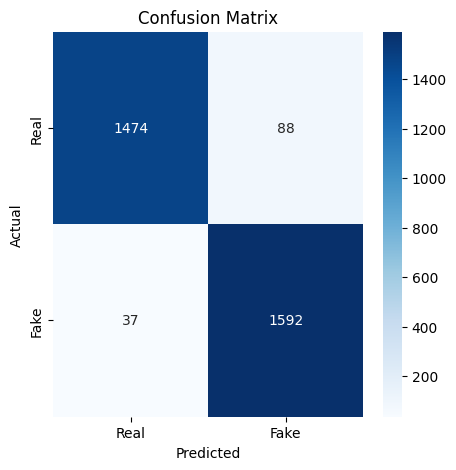

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [57]:
import pickle

# Evaluate the model
loss, accuracy = model_C1.evaluate(padded_test_sequences, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred_prob = model_C1.predict(padded_test_sequences)
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the model with HDF5 format
model_C1.save('hoax_detection_C1.h5')

# Save the model with pickle format
with open('tokenizer_C1.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

### Convert to TFLite

In [58]:
# Convert the model with Select TF ops
converter = tf.lite.TFLiteConverter.from_keras_model(model_C1)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model
with open('hoax_detection_C1.tflite', 'wb') as f:
    f.write(tflite_model)

print('Model has been saved as TensorFlow Lite format.')

Model has been saved as TensorFlow Lite format.


## Model C2

In [59]:
# create model C2
model_C2 = Sequential()
model_C2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model_C2.add(LSTM(32, return_sequences=True))
model_C2.add(Dropout(0.3))
model_C2.add(LSTM(16))
model_C2.add(Dropout(0.3))
model_C2.add(Dense(24, activation='relu'))
model_C2.add(BatchNormalization())
model_C2.add(Dropout(0.3))
model_C2.add(Dense(8, activation='relu'))
model_C2.add(Dropout(0.3))
model_C2.add(Dense(1, activation='sigmoid'))

model_C2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 16)           160000    
                                                                 
 lstm_7 (LSTM)               (None, 100, 32)           6272      
                                                                 
 dropout_12 (Dropout)        (None, 100, 32)           0         
                                                                 
 lstm_8 (LSTM)               (None, 16)                3136      
                                                                 
 dropout_13 (Dropout)        (None, 16)                0         
                                                                 
 dense_14 (Dense)            (None, 24)                408       
                                                                 
 batch_normalization_3 (Bat  (None, 24)               

In [60]:
# compile model
model_C2.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# model training
history = model_C2.fit(padded_train_sequences, y_train,
                      epochs=30,
                      validation_data=(padded_test_sequences, y_test),
                      batch_size=64,
                      callbacks=[early_stopping])

Epoch 1/30
200/200 [==============================] - 37s 148ms/step - loss: 0.6818 - accuracy: 0.5707 - val_loss: 0.6830 - val_accuracy: 0.7819
Epoch 2/30
200/200 [==============================] - 29s 145ms/step - loss: 0.4483 - accuracy: 0.8292 - val_loss: 0.3433 - val_accuracy: 0.9376
Epoch 3/30
200/200 [==============================] - 27s 136ms/step - loss: 0.2698 - accuracy: 0.9166 - val_loss: 0.1678 - val_accuracy: 0.9505
Epoch 4/30
200/200 [==============================] - 28s 142ms/step - loss: 0.2101 - accuracy: 0.9396 - val_loss: 0.1357 - val_accuracy: 0.9568
Epoch 5/30
200/200 [==============================] - 28s 139ms/step - loss: 0.1656 - accuracy: 0.9573 - val_loss: 0.1186 - val_accuracy: 0.9602
Epoch 6/30
200/200 [==============================] - 29s 143ms/step - loss: 0.1373 - accuracy: 0.9664 - val_loss: 0.1086 - val_accuracy: 0.9633
Epoch 7/30
200/200 [==============================] - 29s 143ms/step - loss: 0.1076 - accuracy: 0.9754 - val_loss: 0.1042 - val_ac

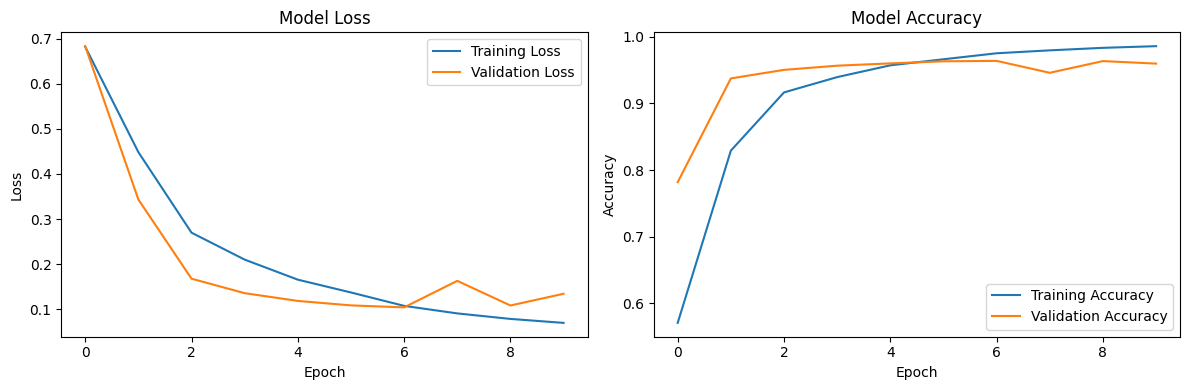

In [61]:
# training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

### Evaluate and save model

100/100 [==============================] - 3s 33ms/step - loss: 0.1042 - accuracy: 0.9640
Test Accuracy: 96.40%
100/100 [==============================] - 4s 28ms/step


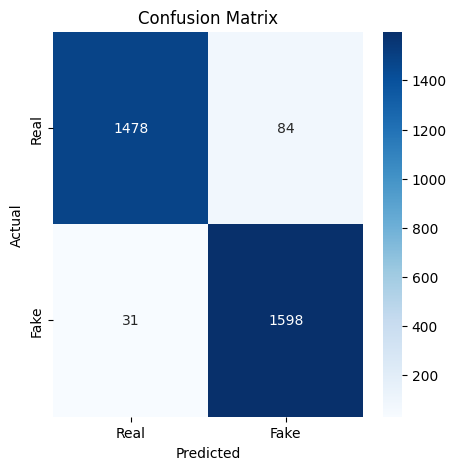

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [62]:
import pickle

# Evaluate the model
loss, accuracy = model_C2.evaluate(padded_test_sequences, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

y_pred_prob = model_C2.predict(padded_test_sequences)
y_pred = (y_pred_prob > 0.5).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title("Confusion Matrix")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Save the model with HDF5 format
model_C2.save('hoax_detection_C2.h5')

# Save the model with pickle format
with open('tokenizer_C2.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

### Convert to TFLite

In [63]:
# Convert the model with Select TF ops
converter = tf.lite.TFLiteConverter.from_keras_model(model_C2)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

# Save the model
with open('hoax_detection_C2.tflite', 'wb') as f:
    f.write(tflite_model)

print('Model has been saved as TensorFlow Lite format.')

Model has been saved as TensorFlow Lite format.


# Download model

In [64]:
files.download("hoax_detection_A1.tflite")
files.download("hoax_detection_A1.h5")
files.download("hoax_detection_A2.tflite")
files.download("hoax_detection_A2.h5")
files.download("hoax_detection_A3.tflite")
files.download("hoax_detection_A3.h5")
files.download("hoax_detection_B1.tflite")
files.download("hoax_detection_B1.h5")
files.download("hoax_detection_B2.tflite")
files.download("hoax_detection_B2.h5")
files.download("hoax_detection_B3.tflite")
files.download("hoax_detection_B3.h5")
files.download("hoax_detection_C1.tflite")
files.download("hoax_detection_C1.h5")
files.download("hoax_detection_C2.tflite")
files.download("hoax_detection_C2.h5")
files.download("tokenizer_A1.pkl")
files.download("tokenizer_A2.pkl")
files.download("tokenizer_A3.pkl")
files.download("tokenizer_B1.pkl")
files.download("tokenizer_B2.pkl")
files.download("tokenizer_B3.pkl")
files.download("tokenizer_C1.pkl")
files.download("tokenizer_C2.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Testing

In [122]:
import pickle
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences

# Load tokenizer from pickle file
with open('tokenizer_C2.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Load TFLite model
interpreter = tf.lite.Interpreter(model_path='hoax_detection_C2.tflite')
interpreter.allocate_tensors()

# Get input and output tensor information
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# news you want to predict [A: 4, A2: 3, A3:3, A4: 3, B: 3, C: 4, C2: 4, C4: 4]
#news_text = ["Ketua Umum Partai Gerindra Prabowo Subianto mempromosikan produk sprei. Dalam video tersebut, Prabowo mengatakan akan membagikan ribuan sprei karena berhasil menang satu putaran dalam Pemilihan Presiden (Pilpres) 2024."]
#news_text = ["Dewan Kehormatan Penyelenggara Pemilu (DKPP) belum menjadwalkan sidang terhadap aduan soal dugaan perbuatan asusila oleh Ketua KPU RI Hasyim Asy'ari terhadap anggota Panitia Pemilihan Luar Negeri (PPLN) yang bertugas di Eropa."]
#news_text = ["Serangan Israel ini menewaskan puluhan warga, termasuk anak-anak. Meskipun sudah berkali-kali saya sampaikan, tapi saya ingin mengulang lagi bahwa Indonesia mengecam keras serangan Israel ke Rafah"]
#news_text = ["Penggalian Jalan Tol di daerah Jawa Timur mengeluarkan Minyak Mentah dengan potensi yang cukup besar"]
#news_text = ["Bendungan Sepaku Semoi di Kabupaten Penajam Paser Utara akan memasok air baku untuk IKN sebesar 2.000 liter per detik."]
#news_text = ["Presiden Joko Widodo atau Jokowi mengecam keras serangan Israel ke Kota Rafah, Gaza Selatan, Palestina. Serangan Israel ini menewaskan puluhan warga, termasuk anak-anak. Meskipun sudah berkali-kali saya sampaikan, tapi saya ingin mengulang lagi bahwa Indonesia mengecam keras serangan Israel ke Rafah kata Jokowi di Kota Dumai, Riau, Sabtu (1/6/2024). Dia meminta Israel untuk menataati perintah dari Mahkamah Internasional. Termasuk, menghentikan serangan ke Kota Rafah, Gaza, Palestina. Dan Israel mestinya memiliki kewajiban untuk mentaati mahkamah internasional, termasuk penghentian serangan ke Palestina jelasnya. "]
news_text = ["Dishub bekerja sama dengan Polri akan menggelar razia kendaraan yang mati pajak, bagi kendaraan yang telat membayar pajak selama 3 tahun atau lebih, kendaraan akan langsung ditahan. Pada pesan tersebut juga menyertakan jadwal razia yang akan dilakukan. Bagi kendaraan yang telat bayar pajak. Berdasarkan data, ada ratusan ribu motor dan mobil yang belum bayar pajak yang masih menggunakan pelat lama. Bagi kendaraan yang telat bayar pajak 3 tahun atau lebih akan langsung dikandangin."]

# Tokenization and padding of news
new_sequences = tokenizer.texts_to_sequences(news_text)
max_len = 100  # Make sure the maximum length matches the one used when training the model
new_padded = pad_sequences(new_sequences, maxlen=max_len)

# Convert input data to float32 type
new_padded = new_padded.astype('float32')

# Set the input tensor with compacted data
interpreter.set_tensor(input_details[0]['index'], new_padded)

# Run the interpreter to make predictions
interpreter.invoke()

# Get the prediction result from the output tensor
predictions_tflite = interpreter.get_tensor(output_details[0]['index'])

# Interpreting prediction results
predicted_labels_tflite = [1 if pred > 0.5 else 0 for pred in predictions_tflite]

# Show the prediction result
for text, pred, label in zip(news_text, predictions_tflite, predicted_labels_tflite):
    print(f'Text: {text}')
    print(f'Prediction: {pred[0]:.4f}')
    print(f'Predicted Label: {"Hoax" if label == 1 else "Not Hoax"}')

Text: Dishub bekerja sama dengan Polri akan menggelar razia kendaraan yang mati pajak, bagi kendaraan yang telat membayar pajak selama 3 tahun atau lebih, kendaraan akan langsung ditahan. Pada pesan tersebut juga menyertakan jadwal razia yang akan dilakukan. Bagi kendaraan yang telat bayar pajak. Berdasarkan data, ada ratusan ribu motor dan mobil yang belum bayar pajak yang masih menggunakan pelat lama. Bagi kendaraan yang telat bayar pajak 3 tahun atau lebih akan langsung dikandangin.
Prediction: 0.8528
Predicted Label: Hoax
